## Outline

1. Modified SN class
2. Overall setup - What is the data, model, task
3. Plotting functions - 3d, contour
4. Individual algorithms and how they perform
5. Exercise

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.colors

from matplotlib import animation, rc
from IPython.display import HTML

import numpy as np

In [9]:
class SN:
  
  def __init__(self, w_init, b_init, algo):
    self.w = w_init
    self.b = b_init
    self.w_h = []
    self.b_h = []
    self.e_h = []
    self.algo = algo
    
  def sigmoid(self, x, w=None, b=None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    return 1. / (1. + np.exp(-(w*x + b)))
  
  def error(self, X, Y, w=None, b=None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    err = 0
    for x, y in zip(X, Y):
      err += 0.5 * (self.sigmoid(x, w, b) - y) ** 2
    return err
  
  def grad_w(self, x, y, w=None, b=None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    y_pred = self.sigmoid(x, w, b)
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b(self, x, y, w=None, b=None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    y_pred = self.sigmoid(x, w, b)
    return (y_pred - y) * y_pred * (1 - y_pred)
  
  def fit(self, X, Y, 
          epochs=100, eta=0.01, gamma=0.9, mini_batch_size=100, eps=1e-8,  
          beta=0.9, beta1=0.9, beta2=0.9
         ):
    self.w_h = []
    self.b_h = []
    self.e_h = []
    self.X = X
    self.Y = Y
    
    if self.algo == 'GD':
      for i in range(epochs):
        dw, db = 0, 0
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y)
          db += self.grad_b(x, y)
        self.w -= eta * dw / X.shape[0]
        self.b -= eta * db / X.shape[0]
        self.append_log()
        
    elif self.algo == 'MiniBatch':
      for i in range(epochs):
        dw, db = 0, 0
        points_seen = 0
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y)
          db += self.grad_b(x, y)
          points_seen += 1
          if points_seen % mini_batch_size == 0:
            self.w -= eta * dw / mini_batch_size
            self.b -= eta * db / mini_batch_size
            self.append_log()
            dw, db = 0, 0
        
    elif self.algo == 'Momentum':
      v_w, v_b = 0, 0
      for i in range(epochs):
        dw, db = 0, 0
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y)
          db += self.grad_b(x, y)
        v_w = gamma * v_w + eta * dw 
        v_b = gamma * v_b + eta * db
        self.w = self.w - v_w
        self.b = self.b - v_b
        self.append_log()
        
    elif self.algo == 'NAG':
      v_w, v_b = 0, 0
      for i in range(epochs):
        dw, db = 0, 0
        v_w = gamma * v_w
        v_b = gamma * v_b
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y, self.w - v_w, self.b - v_b)
          db += self.grad_b(x, y, self.w - v_w, self.b - v_b)
        v_w = v_w + eta * dw
        v_b = v_b + eta * db
        self.w = self.w - v_w
        self.b = self.b - v_b
        self.append_log()
       
            
    elif self.algo == 'AdaGrad':
      v_w, v_b = 0, 0
      for i in range(epochs):
        dw, db = 0, 0
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y)
          db += self.grad_b(x, y)
        v_w += dw**2
        v_b += db**2
        self.w -= (eta / np.sqrt(v_w) + eps) * dw
        self.b -= (eta / np.sqrt(v_b) + eps) * db
        self.append_log()
        
    elif self.algo == 'RMSProp':
      v_w, v_b = 0, 0
      for i in range(epochs):
        dw, db = 0, 0
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y)
          db += self.grad_b(x, y)
        v_w = beta * v_w + (1 - beta) * dw**2
        v_b = beta * v_b + (1 - beta) * db**2
        self.w -= (eta / np.sqrt(v_w) + eps) * dw
        self.b -= (eta / np.sqrt(v_b) + eps) * db
        self.append_log()
        
    elif self.algo == 'Adam':
      v_w, v_b = 0, 0
      m_w, m_b = 0, 0
      num_updates = 0
      for i in range(epochs):
        dw, db = 0, 0
        for x, y in zip(X, Y):
          dw = self.grad_w(x, y)
          db = self.grad_b(x, y)
          num_updates += 1
          m_w = beta1 * m_w + (1-beta1) * dw
          m_b = beta1 * m_b + (1-beta1) * db
          v_w = beta2 * v_w + (1-beta2) * dw**2
          v_b = beta2 * v_b + (1-beta2) * db**2
          m_w_c = m_w / (1 - np.power(beta1, num_updates))
          m_b_c = m_b / (1 - np.power(beta1, num_updates))
          v_w_c = v_w / (1 - np.power(beta2, num_updates))
          v_b_c = v_b / (1 - np.power(beta2, num_updates))
          self.w -= (eta / np.sqrt(v_w_c) + eps) * m_w_c
          self.b -= (eta / np.sqrt(v_b_c) + eps) * m_b_c
          self.append_log()
        
  def append_log(self):
    self.w_h.append(self.w)
    self.b_h.append(self.b)
    self.e_h.append(self.error(self.X, self.Y))

In [82]:
X = np.asarray([3.5,0.35,3.2])
Y = np.asarray([0.49, 0.53, 0.52])

algo = 'NAG'

w_init = 2.1
b_init = 4.0

#w_init = -3
#b_init = 4

#w_init = -5
#b_init = 4

epochs = 100
eta = 1
gamma = 0.8

w_min = -7
w_max = 5

b_min = -5
b_max = 5

animation_frames = 20

plot_3d = True
plot_2d = False

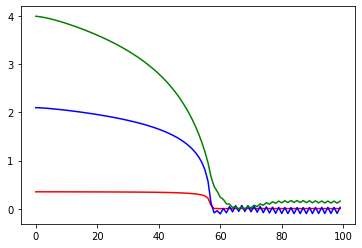

In [83]:
sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epochs=epochs, eta=eta, gamma=gamma)
plt.plot(sn.e_h, 'r')
plt.plot(sn.w_h, 'b')
plt.plot(sn.b_h, 'g')
# w_diff = [t - s for t, s in zip(sn.w_h, sn.w_h[1:])]
# b_diff = [t - s for t, s in zip(sn.b_h, sn.b_h[1:])]
# plt.plot(w_diff, 'b--')
# plt.plot(b_diff, 'g--')
plt.show()

In [84]:
def plot_animate_3d(i):
  i = int(i*(epochs/animation_frames))
  line1.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
  line1.set_3d_properties(sn.e_h[:i+1])
  line2.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
  line2.set_3d_properties(np.zeros(i+1) - 1)
  title.set_text('Epoch: {: d}, Error: {:.4f}'.format(i, sn.e_h[i]))
  return line1, line2, title

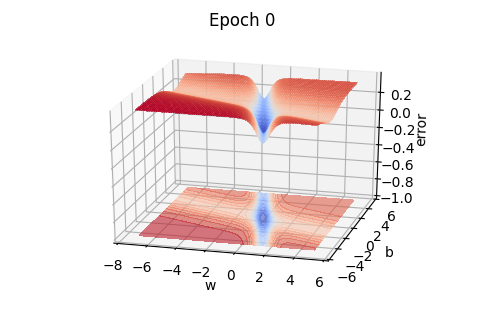

In [85]:
if plot_3d: 
  W = np.linspace(w_min, w_max, 256)
  b = np.linspace(b_min, b_max, 256)
  WW, BB = np.meshgrid(W, b)
  Z = sn.error(X, Y, WW, BB)

  fig = plt.figure(dpi=100)
  ax = fig.gca(projection='3d')
  surf = ax.plot_surface(WW, BB, Z, rstride=3, cstride=3, alpha=0.5, cmap=cm.coolwarm, linewidth=0, antialiased=False)
  cset = ax.contourf(WW, BB, Z, 25, zdir='z', offset=-1, alpha=0.6, cmap=cm.coolwarm)
  ax.set_xlabel('w')
  ax.set_xlim(w_min - 1, w_max + 1)
  ax.set_ylabel('b')
  ax.set_ylim(b_min - 1, b_max + 1)
  ax.set_zlabel('error')
  ax.set_zlim(-1, np.max(Z))
  ax.view_init (elev=25, azim=-75) # azim = -20
  ax.dist=12  
  title = ax.set_title('Epoch 0')



In [86]:
if plot_3d: 
  i = 0
  line1, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], sn.e_h[:i+1], color='black',marker='.')
  line2, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], np.zeros(i+1) - 1, color='red', marker='.')
  anim = animation.FuncAnimation(fig, func=plot_animate_3d, frames=animation_frames)
  rc('animation', html='jshtml')
  anim

In [87]:
if plot_2d: 
  W = np.linspace(w_min, w_max, 256)
  b = np.linspace(b_min, b_max, 256)
  WW, BB = np.meshgrid(W, b)
  Z = sn.error(X, Y, WW, BB)

  fig = plt.figure(dpi=100)
  ax = plt.subplot(111)
  ax.set_xlabel('w')
  ax.set_xlim(w_min - 1, w_max + 1)
  ax.set_ylabel('b')
  ax.set_ylim(b_min - 1, b_max + 1)
  title = ax.set_title('Epoch 0')
  cset = plt.contourf(WW, BB, Z, 25, alpha=0.6, cmap=cm.bwr)
  plt.show()

In [88]:
def plot_animate_2d(i):
  i = int(i*(epochs/animation_frames))
  line.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
  title.set_text('Epoch: {: d}, Error: {:.4f}'.format(i, sn.e_h[i]))
  return line, title

In [89]:
if plot_2d: 
  i = 0
  line, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], color='black',marker='.')
  anim = animation.FuncAnimation(fig, func=plot_animate_2d, frames=animation_frames)
  rc('animation', html='jshtml')
  anim

In [90]:
if algo == 'GD':
  print('algo = {}, eta = {}'.format(algo, eta))
elif algo == 'Momentum' or algo == 'NAG':
  print('algo = {}, eta = {}, gamma = {}'.format(algo, eta, gamma))
elif algo == 'MiniBatch':
  print('algo = {}, eta = {}, batch size = {}'.format(algo, eta, mini_batch_size))
elif algo == 'AdaGrad' or algo == 'RMSProp':
  print('algo = {}, eta = {}, eps = {}'.format(algo, eta, eps))
anim

algo = NAG, eta = 1, gamma = 0.8
